In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")

# Defining the Physics Functions:

In [2]:
def Force(dic, axis, fixed_planet, M, G):
    '''
    Calculate the gravitational force on a fixed planet in the specified axis.
    Parameters:
        dic (dict): Dictionary of planets in the format - { "pi": [xi, yi, vi, wi] }
        axis (str): Axis ('x' or 'y') along which the force is calculated.
        fixed_planet (str): Name of the fixed planet for force calculation.
        M (float): Common mass of the planets.
        G (float): Gravitational constant.
    Returns:
        float: Total gravitational force on the fixed planet in the specified axis.
    '''
    Planets = dic.keys()
    F = 0
    if axis == 'x':
        for i in Planets:
            if i != fixed_planet:
                F += G * M * (dic[i][0] - dic[fixed_planet][0])/(((dic[i][0] - dic[fixed_planet][0])**2+(dic[i][1] - dic[fixed_planet][1])**2)**(3/2))
    elif axis == 'y':
        for i in Planets:
            if i != fixed_planet:
                F += G * M * (dic[i][1] - dic[fixed_planet][1])/(((dic[i][0] - dic[fixed_planet][0])**2+(dic[i][1] - dic[fixed_planet][1])**2)**(3/2))
    return F

def Velocity(dic, axis, fixed_planet):
    '''
    Get the velocity component of the specified planet along the specified axis.
    Parameters:
        dic (dict): Dictionary of planets in the format - { "pi": [xi, yi, vi, wi] }
        axis (str): Axis ('x' or 'y') for velocity retrieval.
        planet_fixed (str): Name of the planet for velocity retrieval.
    Returns:
        float: Velocity component of the specified planet along the specified axis.
    '''
    if axis == 'x':
        return dic[fixed_planet][2]
    if axis == 'y':
        return dic[fixed_planet][3]

# Verlet Method: 

## Basic Idea:

The Verlet method is based on discretizing the equations of motion in terms of position.

Unlike traditional methods that require both position and velocity, Verlet only requires positions at successive time steps.

## Algorithm:

Given the current position $x(t)$ and an estimate of the second derivative $x''(t)$, the next position $x(t+\Delta t)$ is calculated using the formula:


$$x(t+\Delta t) = 2x(t) - x(t-\Delta t) + x''(t) \Delta t^2 + O(\Delta t^4)$$

This formula is a second-order accurate update scheme. It uses information from the current time step $t$ and the previous time step $t-\Delta t$ to estimate the next position $t+\Delta t$.


In [3]:
def Verlet(dict_, M, G, n_iter, h = 0.01):
    '''
    Simulate the motion of planets using the Verlet integration method.
    Parameters:
        dict_ (dict): Dictionary of planets in the format - { "pi": [xi, yi, vi, wi] }
                      where xi and yi are initial positions, vi and wi are initial velocities.
        n_iter (int): Number of iterations.
        h (float, optional): Time step size. Default is 0.01.
    Returns:
        tuple: A tuple containing two lists - x_pos and y_pos.
               - x_pos: List of lists containing x-positions of each planet over time.
               - y_pos: List of lists containing y-positions of each planet over time.
    '''
    dic = copy.deepcopy(dict_)
    Planets = list(dic.keys())
    x_pos = []
    y_pos = []
    
    # Initialize lists for x and y positions
    for i in Planets:
        x_i, y_i = [dic[i][0]], [dic[i][1]]
        x_pos.append(x_i)
        y_pos.append(y_i)

    # Calculate initial positions after one time step using Verlet method
    for i in range(len(x_pos)):
        fixed_planet = Planets[i]
        x_pos[i].append(x_pos[i][-1] + h*Velocity(dic, 'x', Planets[i]) + (h**2)*(Force(dic, 'x', fixed_planet, M, G)/2))
        y_pos[i].append(y_pos[i][-1] + h*Velocity(dic, 'y', Planets[i]) + (h**2)*(Force(dic, 'y', fixed_planet, M, G)/2))
    
    # Perform Verlet integration for n_iter iterations
    for _ in range(n_iter):
        for i in range(len(x_pos)):
            fixed_planet = Planets[i]
            x_pos[i].append(2*x_pos[i][-1] - x_pos[i][-2] + (h**2)*(Force(dic, 'x', fixed_planet, M, G)))
            y_pos[i].append(2*y_pos[i][-1] - y_pos[i][-2] + (h**2)*(Force(dic, 'y', fixed_planet, M, G)))
        # Update the dictionary with the final positions
        for i in range(len(x_pos)):
            dic[Planets[i]][0] = x_pos[i][-1]
            dic[Planets[i]][1] = y_pos[i][-1]
    return x_pos, y_pos

# Range Kuta 4:

## Basic Idea:

The fourth-order Runge-Kutta (RK4) method is a numerical technique used to approximate solutions to ordinary differential equations (ODEs). It is particularly effective for simulating the motion of planets and other dynamic systems. RK4 improves upon simpler methods like Euler's method by providing a more accurate and stable solution.

## Algorithm:

Given an initial position $x(t_0)$ and an estimate of the derivative $x'(t_0)$ at time $t_0$, RK4 calculates the next position $x(t_0 + \Delta t)$ using the following steps:

1. Calculate the time step: $\Delta t = t_{n+1} - t_n$.

2. Use the following formulas to estimate the intermediate values:

$$
\begin{align*}
k_1 &= \Delta t \cdot f(t_n, x_n) \\
k_2 &= \Delta t \cdot f(t_n + \frac{\Delta t}{2}, x_n + \frac{k_1}{2}) \\
k_3 &= \Delta t \cdot f(t_n + \frac{\Delta t}{2}, x_n + \frac{k_2}{2}) \\
k_4 &= \Delta t \cdot f(t_n + \Delta t, x_n + k_3) \\
\end{align*}
$$


where $f(t, x)$ represents the derivative of $x$ with respect to $t$.

3. Use the intermediate values to update the position:
$$x_{n+1} = x_n + \frac{1}{6} \cdot (k_1 + 2k_2 + 2k_3 + k_4)$$

This formula provides a fourth-order accurate update scheme, offering a more precise estimation of the next position based on information from the current time step $t_n$ and intermediate steps.


In [4]:
def RK4(dict_, M, G, n_iter, h = 0.01):
    '''
    Simulate the motion of planets using the fourth-order Runge-Kutta (RK4) method.
    Parameters:
        dict_ (dict): Dictionary of planets in the format - { "pi": [xi, yi, vi, wi] }
                      where xi and yi are initial positions, vi and wi are initial velocities.
        n_iter (int): Number of iterations.
        h (float, optional): Time step size. Default is 0.01.
    Returns:
        tuple: A tuple containing two lists - x_pos and y_pos.
               - x_pos: List of lists containing x-positions of each planet over time.
               - y_pos: List of lists containing y-positions of each planet over time.
    '''
    dic = copy.deepcopy(dict_)
    Planets = list(dic.keys())
    Planets_list = list(dic.values())

    x_pos = []  
    y_pos = []  
    for i in Planets:
        x_i, y_i = [dic[i][0]], [dic[i][1]]
        x_pos.append(x_i)
        y_pos.append(y_i)

    # Combine all initial positions and velocities into a single list u_n
    u_n = [] 
    for i in range(len(Planets_list)):
        for j in range(len(Planets_list[i])):
              u_n.append(Planets_list[i][j])
    u_n = [u_n] 

    # Define functions for calculating velocities and forces
    du_n = [Velocity, Velocity, Force, Force]
    axs = ['x', 'y', 'x', 'y']

    for _ in range(n_iter):
        dic2 = copy.deepcopy(dic)  # Create a copy of the dictionary for intermediate calculations

        # Calculate k1
        k1 = []
        for i in range(len(Planets)):
            for j in range(len(axs)):
                if du_n[j] == Velocity:
                    k1.append(du_n[j](dic2, axs[j], Planets[i]))
                else:
                    k1.append(du_n[j](dic2, axs[j], Planets[i], M, G))
        # Update dic2 for calculating k2
        for i in range(len(Planets)):
            dic2[Planets[i]] = np.array(dic[Planets[i]]) + (h*np.array(k1[4*i:4*(i+1)])/2)

        # Calculate k2
        k2 = []
        for i in range(len(Planets)):
            for j in range(len(axs)):
                if du_n[j] == Velocity:
                    k2.append(du_n[j](dic2, axs[j], Planets[i]))
                else:
                    k2.append(du_n[j](dic2, axs[j], Planets[i], M, G))
        # Update dic2 for calculating k3
        for i in range(len(Planets)):
            dic2[Planets[i]] = np.array(dic[Planets[i]]) + (h*np.array(k2[4*i:4*(i+1)])/2)

        # Calculate k3
        k3 = []
        for i in range(len(Planets)):
            for j in range(len(axs)):
                if du_n[j] == Velocity:
                    k3.append(du_n[j](dic2, axs[j], Planets[i]))
                else:
                    k3.append(du_n[j](dic2, axs[j], Planets[i], M, G))
                    
        # Update dic2 for calculating k4
        for i in range(len(Planets)):
            dic2[Planets[i]] = np.array(dic[Planets[i]]) + (h*np.array(k3[4*i:4*(i+1)]))

        # Calculate k4
        k4 = []
        for i in range(len(Planets)):
            for j in range(len(axs)):
                if du_n[j] == Velocity:
                    k4.append(du_n[j](dic2, axs[j], Planets[i]))
                else:
                    k4.append(du_n[j](dic2, axs[j], Planets[i], M, G))
        # Calculate new u_n using RK4 formula
        new_u_n = np.array(u_n[-1]) + (h/6)*(np.array(k1) + 2*np.array(k2) + 2*np.array(k3) + np.array(k4))
        u_n.append(new_u_n)

        # Update positions
        for i in range(len(Planets)):
            x_pos[i].append(u_n[-1][4*i])
            y_pos[i].append(u_n[-1][(4*i) + 1])

        # Update the dictionary with the final positions
        for i in range(len(Planets)):
            dic[Planets[i]] = np.array(new_u_n[4*i:4*(i+1)])

    return x_pos, y_pos

# No. 1:

In [5]:
v = [0.5, 0.2]
n_iter = 2000
M = 1e8
G = 1e-8
planets_dict = {'P1': [1, 0, v[0], v[1]], 'P2':[-1, 0, -v[0], -v[1]]}
Verlet_x, Verlet_y = Verlet(planets_dict, M, G, n_iter)
RK4_x, RK4_y = RK4(planets_dict, M, G, n_iter)

Verlet method:

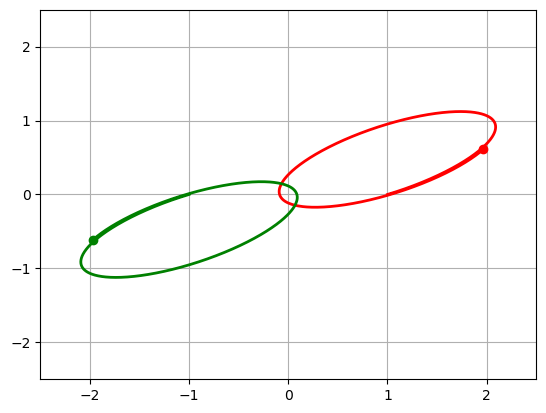

In [6]:
fig = plt.figure() 
ax = plt.axes(xlim=(-2.5, 2.5), ylim=(-2.5, 2.5)) 
line, = ax.plot([], [], lw=2, color='red')
line2, = ax.plot([], [], lw=2, color='green')
point, = ax.plot([], [], 'ro')
point2, = ax.plot([], [], 'go')
xdata, ydata = [], [] 
xdata2, ydata2 = [], [] 
point_x, point_y = [], []
point_x2, point_y2 = [], []

def animate(i): 
    xdata.append(Verlet_x[0][i])
    ydata.append(Verlet_y[0][i])
    
    xdata2.append(Verlet_x[1][i])
    ydata2.append(Verlet_y[1][i])

    line.set_data(xdata, ydata)
    point.set_data(xdata[-1], ydata[-1])
    line2.set_data(xdata2, ydata2)
    point2.set_data(xdata2[-1], ydata2[-1])
    
    return line, line2, point, point2

ax.grid()
anim = animation.FuncAnimation(fig, animate, frames=2000, interval=5, blit=True) 
HTML(anim.to_html5_video())

RK4 method:

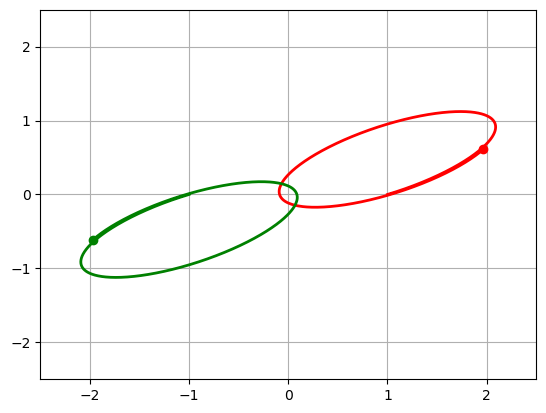

In [7]:
fig = plt.figure() 
ax = plt.axes(xlim=(-2.5, 2.5), ylim=(-2.5, 2.5)) 
line, = ax.plot([], [], lw=2, color='red')
line2, = ax.plot([], [], lw=2, color='green')
point, = ax.plot([], [], 'ro')
point2, = ax.plot([], [], 'go')
xdata, ydata = [], [] 
xdata2, ydata2 = [], [] 
point_x, point_y = [], []
point_x2, point_y2 = [], []

def animate(i): 
    xdata.append(Verlet_x[0][i])
    ydata.append(Verlet_y[0][i])
    
    xdata2.append(Verlet_x[1][i])
    ydata2.append(Verlet_y[1][i])

    line.set_data(xdata, ydata)
    line2.set_data(xdata2, ydata2)
    point.set_data(xdata[-1], ydata[-1])
    point2.set_data(xdata2[-1], ydata2[-1])
    
    return line, line2, point, point2

ax.grid()
anim = animation.FuncAnimation(fig, animate, frames=2000, interval=5, blit=True) 
HTML(anim.to_html5_video())

# No. 2

In [8]:
v = [0.322184765624991, 0.647989160156249]
n_iter = 2000
M = 1e8
G = 1e-8
planets_dict = {'P1': [-1, 0, v[0], v[1]], 'P2':[1, 0, v[0], v[1]], 'P3':[0, 0, -2*v[0], -2*v[1]]}
Verlet_x, Verlet_y = Verlet(planets_dict, M, G, n_iter)
RK4_x, RK4_y = RK4(planets_dict, M, G, n_iter)

Verlet method:

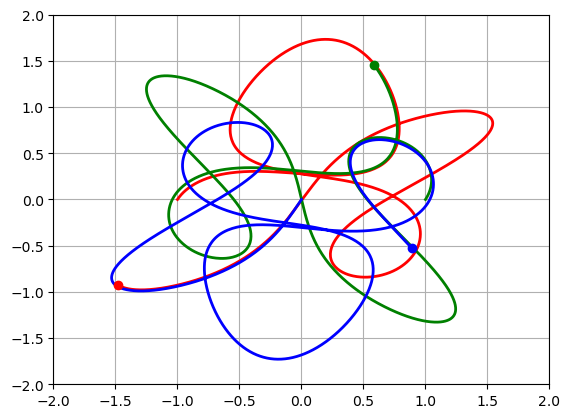

In [9]:
fig = plt.figure() 
ax = plt.axes(xlim=(-2, 2), ylim=(-2, 2)) 
line, = ax.plot([], [], lw=2, color='red')
line2, = ax.plot([], [], lw=2, color='green')
line3, = ax.plot([], [], lw=2, color='blue')

point, = ax.plot([], [], 'ro')
point2, = ax.plot([], [], 'go')
point3, = ax.plot([], [], 'bo')

xdata, ydata = [], [] 
xdata2, ydata2 = [], [] 
xdata3, ydata3 = [], [] 

point_x, point_y = [], []
point_x2, point_y2 = [], []
point_x3, point_y3 = [], []

def animate(i): 
    xdata.append(Verlet_x[0][i])
    ydata.append(Verlet_y[0][i])
    
    xdata2.append(Verlet_x[1][i])
    ydata2.append(Verlet_y[1][i])
    
    xdata3.append(Verlet_x[2][i])
    ydata3.append(Verlet_y[2][i])
    
    line.set_data(xdata, ydata)
    line2.set_data(xdata2, ydata2)
    line3.set_data(xdata3, ydata3)
    
    point.set_data(xdata[-1], ydata[-1])
    point2.set_data(xdata2[-1], ydata2[-1])
    point3.set_data(xdata3[-1], ydata3[-1])
    
    return line, line2, line3, point, point2, point3

ax.grid()
anim = animation.FuncAnimation(fig, animate, frames=2000, interval=10, blit=True) 
HTML(anim.to_html5_video())

RK4 method:

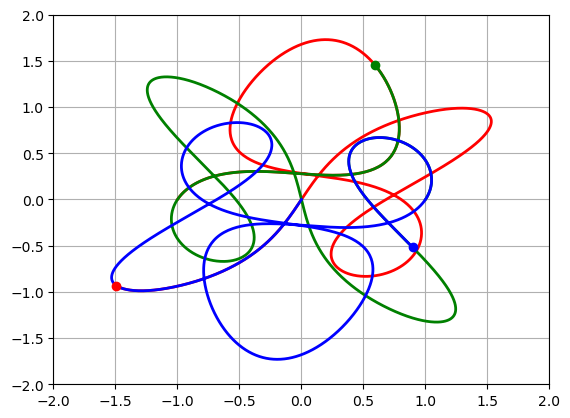

In [10]:
fig = plt.figure() 
ax = plt.axes(xlim=(-2, 2), ylim=(-2, 2)) 
line, = ax.plot([], [], lw=2, color='red')
line2, = ax.plot([], [], lw=2, color='green')
line3, = ax.plot([], [], lw=2, color='blue')
point, = ax.plot([], [], 'ro')
point2, = ax.plot([], [], 'go')
point3, = ax.plot([], [], 'bo')
xdata, ydata = [], [] 
xdata2, ydata2 = [], [] 
xdata3, ydata3 = [], [] 
point_x, point_y = [], []
point_x2, point_y2 = [], []
point_x3, point_y3 = [], []

def animate(i): 
    xdata.append(RK4_x[0][i])
    ydata.append(RK4_y[0][i])
    point_x.append(RK4_x[0][i])
    point_y.append(RK4_y[0][i])
    
    xdata2.append(RK4_x[1][i])
    ydata2.append(RK4_y[1][i])
    point_x2.append(RK4_x[1][i])
    point_y2.append(RK4_y[1][i])
    
    xdata3.append(RK4_x[2][i])
    ydata3.append(RK4_y[2][i])
    point_x3.append(RK4_x[2][i])
    point_y3.append(RK4_y[2][i])
    
    line.set_data(xdata, ydata)
    line2.set_data(xdata2, ydata2)
    line3.set_data(xdata3, ydata3)
    
    point.set_data(point_x[-1], point_y[-1])
    point2.set_data(point_x2[-1], point_y2[-1])
    point3.set_data(point_x3[-1], point_y3[-1])
    
    return line, line2, line3, point, point2, point3

ax.grid()
anim = animation.FuncAnimation(fig, animate, frames=2000, interval=10, blit=True) 
HTML(anim.to_html5_video())

# No. 3:

In [11]:
v = [0.257841699218752, 0.687880761718747]
n_iter = 2000
M = 1e8
G = 1e-8
planets_dict = {'P1': [-1, 0, v[0], v[1]], 'P2':[1, 0, v[0], v[1]], 'P3':[0, 0, -2*v[0], -2*v[1]]}
Verlet_x, Verlet_y = Verlet(planets_dict, M, G, n_iter)
RK4_x, RK4_y = RK4(planets_dict, M, G, n_iter)
#h=0.002

Verlet Method:

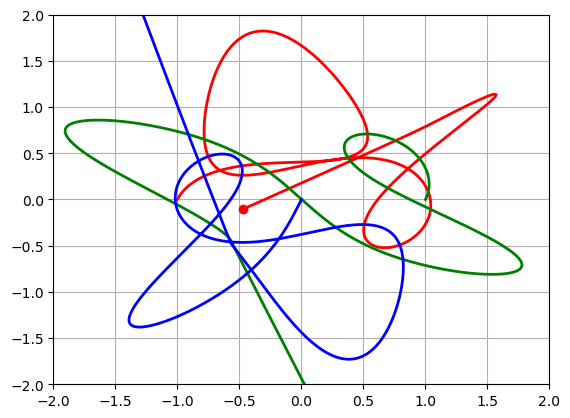

In [12]:
fig = plt.figure() 
ax = plt.axes(xlim=(-2, 2), ylim=(-2, 2)) 
line, = ax.plot([], [], lw=2, color='red')
line2, = ax.plot([], [], lw=2, color='green')
line3, = ax.plot([], [], lw=2, color='blue')

point, = ax.plot([], [], 'ro')
point2, = ax.plot([], [], 'go')
point3, = ax.plot([], [], 'bo')

xdata, ydata = [], [] 
xdata2, ydata2 = [], [] 
xdata3, ydata3 = [], [] 

point_x, point_y = [], []
point_x2, point_y2 = [], []
point_x3, point_y3 = [], []

def animate(i): 
    xdata.append(Verlet_x[0][i])
    ydata.append(Verlet_y[0][i])
    
    xdata2.append(Verlet_x[1][i])
    ydata2.append(Verlet_y[1][i])
    
    xdata3.append(Verlet_x[2][i])
    ydata3.append(Verlet_y[2][i])
    
    line.set_data(xdata, ydata)
    line2.set_data(xdata2, ydata2)
    line3.set_data(xdata3, ydata3)
    
    point.set_data(xdata[-1], ydata[-1])
    point2.set_data(xdata2[-1], ydata2[-1])
    point3.set_data(xdata3[-1], ydata3[-1])
    
    return line, line2, line3, point, point2, point3

ax.grid()
anim = animation.FuncAnimation(fig, animate, frames=2000, interval=10, blit=True) 
HTML(anim.to_html5_video())

RK4 Method:

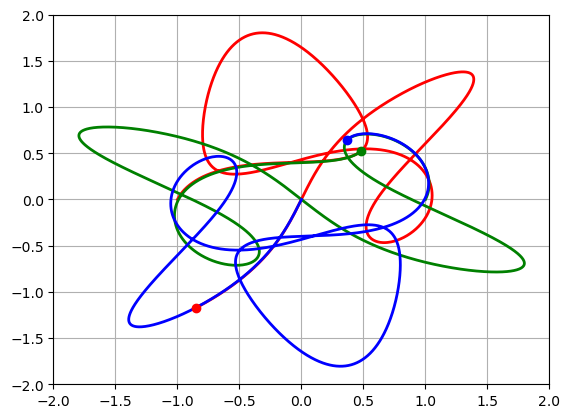

In [13]:
fig = plt.figure() 
ax = plt.axes(xlim=(-2, 2), ylim=(-2, 2)) 
line, = ax.plot([], [], lw=2, color='red')
line2, = ax.plot([], [], lw=2, color='green')
line3, = ax.plot([], [], lw=2, color='blue')
point, = ax.plot([], [], 'ro')
point2, = ax.plot([], [], 'go')
point3, = ax.plot([], [], 'bo')
xdata, ydata = [], [] 
xdata2, ydata2 = [], [] 
xdata3, ydata3 = [], [] 
point_x, point_y = [], []
point_x2, point_y2 = [], []
point_x3, point_y3 = [], []

def animate(i): 
    xdata.append(RK4_x[0][i])
    ydata.append(RK4_y[0][i])
    point_x.append(RK4_x[0][i])
    point_y.append(RK4_y[0][i])
    
    xdata2.append(RK4_x[1][i])
    ydata2.append(RK4_y[1][i])
    point_x2.append(RK4_x[1][i])
    point_y2.append(RK4_y[1][i])
    
    xdata3.append(RK4_x[2][i])
    ydata3.append(RK4_y[2][i])
    point_x3.append(RK4_x[2][i])
    point_y3.append(RK4_y[2][i])
    
    line.set_data(xdata, ydata)
    line2.set_data(xdata2, ydata2)
    line3.set_data(xdata3, ydata3)
    
    point.set_data(point_x[-1], point_y[-1])
    point2.set_data(point_x2[-1], point_y2[-1])
    point3.set_data(point_x3[-1], point_y3[-1])
    
    return line, line2, line3, point, point2, point3

ax.grid()
anim = animation.FuncAnimation(fig, animate, frames=2000, interval=10, blit=True) 
HTML(anim.to_html5_video())

# No. 4:

In [14]:
v = [0.568991007042164, 0.449428951346711]
n_iter = 2000
M = 1e8
G = 1e-8
planets_dict = {'P1': [-1, 0, v[0], v[1]], 'P2':[1, 0, v[0], v[1]], 'P3':[0, 0, -2*v[0], -2*v[1]]}
Verlet_x, Verlet_y = Verlet(planets_dict, M, G, n_iter)
RK4_x, RK4_y = RK4(planets_dict, M, G, n_iter)

Verlet method:

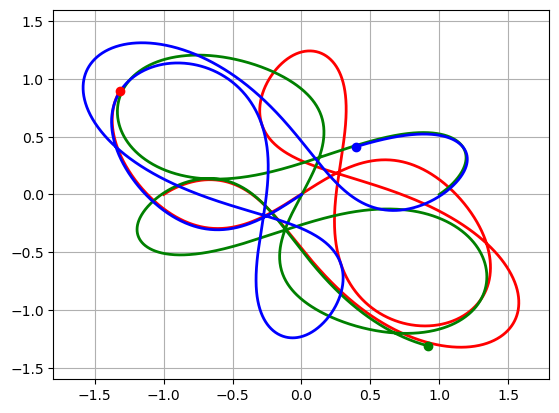

In [15]:
fig = plt.figure() 
ax = plt.axes(xlim=(-1.8, 1.8), ylim=(-1.6, 1.6)) 
line, = ax.plot([], [], lw=2, color='red')
line2, = ax.plot([], [], lw=2, color='green')
line3, = ax.plot([], [], lw=2, color='blue')

point, = ax.plot([], [], 'ro')
point2, = ax.plot([], [], 'go')
point3, = ax.plot([], [], 'bo')

xdata, ydata = [], [] 
xdata2, ydata2 = [], [] 
xdata3, ydata3 = [], [] 

point_x, point_y = [], []
point_x2, point_y2 = [], []
point_x3, point_y3 = [], []

def animate(i): 
    xdata.append(Verlet_x[0][i])
    ydata.append(Verlet_y[0][i])
    
    xdata2.append(Verlet_x[1][i])
    ydata2.append(Verlet_y[1][i])
    
    xdata3.append(Verlet_x[2][i])
    ydata3.append(Verlet_y[2][i])
    
    line.set_data(xdata, ydata)
    line2.set_data(xdata2, ydata2)
    line3.set_data(xdata3, ydata3)
    
    point.set_data(xdata[-1], ydata[-1])
    point2.set_data(xdata2[-1], ydata2[-1])
    point3.set_data(xdata3[-1], ydata3[-1])
    
    return line, line2, line3, point, point2, point3

ax.grid()
anim = animation.FuncAnimation(fig, animate, frames=2000, interval=10, blit=True) 
HTML(anim.to_html5_video())

RK4 method:

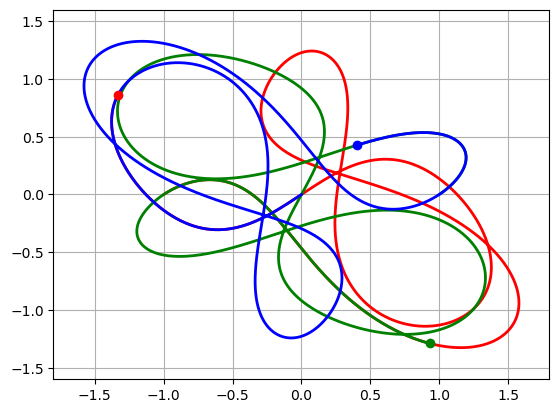

In [16]:
fig = plt.figure() 
ax = plt.axes(xlim=(-1.8, 1.8), ylim=(-1.6, 1.6)) 
line, = ax.plot([], [], lw=2, color='red')
line2, = ax.plot([], [], lw=2, color='green')
line3, = ax.plot([], [], lw=2, color='blue')
point, = ax.plot([], [], 'ro')
point2, = ax.plot([], [], 'go')
point3, = ax.plot([], [], 'bo')
xdata, ydata = [], [] 
xdata2, ydata2 = [], [] 
xdata3, ydata3 = [], [] 
point_x, point_y = [], []
point_x2, point_y2 = [], []
point_x3, point_y3 = [], []

def animate(i): 
    xdata.append(RK4_x[0][i])
    ydata.append(RK4_y[0][i])
    point_x.append(RK4_x[0][i])
    point_y.append(RK4_y[0][i])
    
    xdata2.append(RK4_x[1][i])
    ydata2.append(RK4_y[1][i])
    point_x2.append(RK4_x[1][i])
    point_y2.append(RK4_y[1][i])
    
    xdata3.append(RK4_x[2][i])
    ydata3.append(RK4_y[2][i])
    point_x3.append(RK4_x[2][i])
    point_y3.append(RK4_y[2][i])
    
    line.set_data(xdata, ydata)
    line2.set_data(xdata2, ydata2)
    line3.set_data(xdata3, ydata3)
    
    point.set_data(point_x[-1], point_y[-1])
    point2.set_data(point_x2[-1], point_y2[-1])
    point3.set_data(point_x3[-1], point_y3[-1])
    
    return line, line2, line3, point, point2, point3

ax.grid()
anim = animation.FuncAnimation(fig, animate, frames=2000, interval=10, blit=True) 
HTML(anim.to_html5_video())

# No. 22:

In [17]:
v = [0.698073236083981, 0.328500769042967]
n_iter = 4000
M = 1e8
G = 1e-8
planets_dict = {'P1': [-1, 0, v[0], v[1]], 'P2':[1, 0, v[0], v[1]], 'P3':[0, 0, -2*v[0], -2*v[1]]}
Verlet_x, Verlet_y = Verlet(planets_dict, M, G, n_iter)
RK4_x, RK4_y = RK4(planets_dict, M, G, n_iter)

Verlet Method:

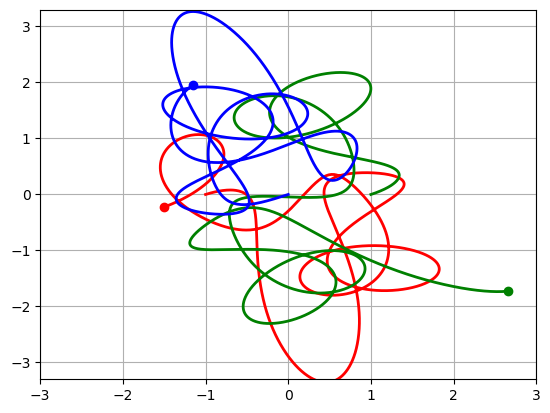

In [18]:
fig = plt.figure() 
ax = plt.axes(xlim=(-3, 3), ylim=(-3.3, 3.3)) 
line, = ax.plot([], [], lw=2, color='red')
line2, = ax.plot([], [], lw=2, color='green')
line3, = ax.plot([], [], lw=2, color='blue')

point, = ax.plot([], [], 'ro')
point2, = ax.plot([], [], 'go')
point3, = ax.plot([], [], 'bo')

xdata, ydata = [], [] 
xdata2, ydata2 = [], [] 
xdata3, ydata3 = [], [] 

point_x, point_y = [], []
point_x2, point_y2 = [], []
point_x3, point_y3 = [], []

def animate(i): 
    xdata.append(Verlet_x[0][i])
    ydata.append(Verlet_y[0][i])
    
    xdata2.append(Verlet_x[1][i])
    ydata2.append(Verlet_y[1][i])
    
    xdata3.append(Verlet_x[2][i])
    ydata3.append(Verlet_y[2][i])
    
    line.set_data(xdata, ydata)
    line2.set_data(xdata2, ydata2)
    line3.set_data(xdata3, ydata3)
    
    point.set_data(xdata[-1], ydata[-1])
    point2.set_data(xdata2[-1], ydata2[-1])
    point3.set_data(xdata3[-1], ydata3[-1])
    
    return line, line2, line3, point, point2, point3

ax.grid()
anim = animation.FuncAnimation(fig, animate, frames=4000, interval=10, blit=True) 
HTML(anim.to_html5_video())

RK4 method:

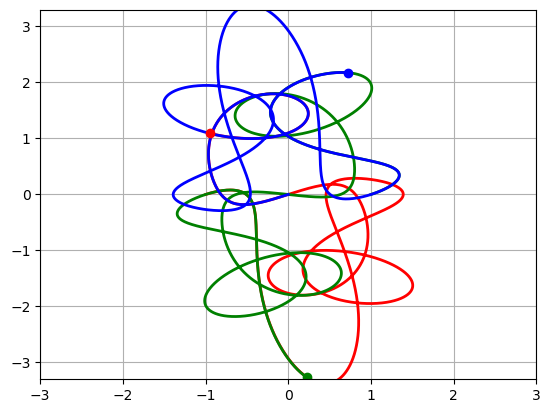

In [19]:
fig = plt.figure() 
ax = plt.axes(xlim=(-3, 3), ylim=(-3.3, 3.3)) 
line, = ax.plot([], [], lw=2, color='red')
line2, = ax.plot([], [], lw=2, color='green')
line3, = ax.plot([], [], lw=2, color='blue')
point, = ax.plot([], [], 'ro')
point2, = ax.plot([], [], 'go')
point3, = ax.plot([], [], 'bo')
xdata, ydata = [], [] 
xdata2, ydata2 = [], [] 
xdata3, ydata3 = [], [] 
point_x, point_y = [], []
point_x2, point_y2 = [], []
point_x3, point_y3 = [], []

def animate(i): 
    xdata.append(RK4_x[0][i])
    ydata.append(RK4_y[0][i])
    point_x.append(RK4_x[0][i])
    point_y.append(RK4_y[0][i])
    
    xdata2.append(RK4_x[1][i])
    ydata2.append(RK4_y[1][i])
    point_x2.append(RK4_x[1][i])
    point_y2.append(RK4_y[1][i])
    
    xdata3.append(RK4_x[2][i])
    ydata3.append(RK4_y[2][i])
    point_x3.append(RK4_x[2][i])
    point_y3.append(RK4_y[2][i])
    
    line.set_data(xdata, ydata)
    line2.set_data(xdata2, ydata2)
    line3.set_data(xdata3, ydata3)
    
    point.set_data(point_x[-1], point_y[-1])
    point2.set_data(point_x2[-1], point_y2[-1])
    point3.set_data(point_x3[-1], point_y3[-1])
    
    return line, line2, line3, point, point2, point3

ax.grid()
anim = animation.FuncAnimation(fig, animate, frames=4000, interval=10, blit=True) 
HTML(anim.to_html5_video())